For personal use only

As bidding wars in NJ last for several years. You never know, how much should you offer over asking proce to get the house.
But let's try to find out.

In [1]:
import json
import httpx

from parsel import Selector

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
l = list()

Here are some towns I am interested in.

In [4]:
towns_list = ['berkeley-heights-township', 'mountainside', 'long-hill-township', 'warren', 'watchung', 'bernards-township', 'new-providence']

I am using the web-site "www.rockethomes.com"  as it shows both listed and sold price on 1 page.
Here I am using BeautifulSoup to scrap the data.

In [5]:
for town in towns_list:

    url = "https://www.rockethomes.com/nj/"+town+"?listing-status=sold"
    
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    
    properties = soup.find_all("div",{"class":"p2 transition relative flex h-full w-full flex-col overflow-hidden rounded-8 bg-white text-left shadow-3 hover:shadow-7 w-full"})
    for x in range(0,len(properties)):
        obj={}
        try:
            obj["sold_price"]=properties[x].find("p",{"class":"mr-12 sprk-b-TypeBodyOne"}).text
        except:
            obj["sold_price"]=None
        try:
            obj["list_price"]=properties[x].find("p",{"class":"line-through text-sprk-black-tint-60 sprk-b-TypeBodyFour"}).text
        except:
            obj["list_price"]=None
        try:
            obj["bdr"]=properties[x].find("p",{"data-testid": "beds"}).text
        except:
            obj["bdr"]=None
        try:
            obj["address"]=properties[x].find("p",{"class":"truncate pb-4 sprk-b-TypeBodyFour"}).text
        except:
            obj["address"]=None
        l.append(obj)
    



Let's put everything into pandas dataframe 

In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame(l)

In [8]:
df

,sold_price,list_price,bdr,address
0,"$1,199,000",None,4,"630 Plainfield Ave, Berkeley Heights Twp NJ, 0..."
1,"$675,000","$699,000",5,"60 Ralph Pl, Berkeley Heights Twp NJ, 07922"
2,"$625,000",None,3,"47 Hamilton Ave, Berkeley Heights Twp NJ, 07922"
3,"$725,000","$675,000",4,"43 Beech Ave, Berkeley Heights Twp NJ, 07922"
4,"$750,000","$749,900",6,"379 Snyder Ave, Berkeley Heights Twp NJ, 07922"
...,...,...,...,...
151,"$803,000","$729,000",3,"15 Hillside Ter, New Providence Boro NJ, 07901"
152,"$691,250","$585,000",3,"6 Magnolia Dr, New Providence Boro NJ, 07974"
153,"$500,000","$515,000",3,"244 Livingston Ave, New Providence Boro NJ, 07..."
154,"$999,000",None,4,"232 S St Unit 1, New Providence Boro NJ, 07974"


In [9]:
df = df.loc[df['list_price'].notna()]

In [10]:
df.loc[:, 'sold_price'] = df.loc[:, 'sold_price'].str.replace(('\$'), '',regex=True).str.replace((','), '',regex=True)
df.loc[:, 'list_price'] = df.loc[:, 'list_price'].str.replace(('\$'), '',regex=True).str.replace((','), '',regex=True)

Also I am turning price column into regular numbers 

In [11]:
df.head()

,sold_price,list_price,bdr,address
1,675000,699000,5,"60 Ralph Pl, Berkeley Heights Twp NJ, 07922"
3,725000,675000,4,"43 Beech Ave, Berkeley Heights Twp NJ, 07922"
4,750000,749900,6,"379 Snyder Ave, Berkeley Heights Twp NJ, 07922"
5,527000,445000,3,"3 Castle Dr, Berkeley Heights Twp NJ, 07922"
6,450000,449900,2,"34 Angela Way, Berkeley Heights Twp NJ, 07922"


In [12]:
df = df.astype({"sold_price": float, "list_price": float})

Let's define the difference of sold and listed price:

In [13]:
df['bidding'] = df['sold_price'] - df['list_price']

As I want to compare, which town is easier to get into, I am splitting the address cell:

In [14]:
df_cleaned = pd.concat([df, df['address'].str.split(pat = ', ', expand = True)], axis = 1)

In [15]:
df_cleaned.head()

,sold_price,list_price,bdr,address,bidding,0,1,2
1,675000.0,699000.0,5,"60 Ralph Pl, Berkeley Heights Twp NJ, 07922",-24000.0,60 Ralph Pl,Berkeley Heights Twp NJ,07922
3,725000.0,675000.0,4,"43 Beech Ave, Berkeley Heights Twp NJ, 07922",50000.0,43 Beech Ave,Berkeley Heights Twp NJ,07922
4,750000.0,749900.0,6,"379 Snyder Ave, Berkeley Heights Twp NJ, 07922",100.0,379 Snyder Ave,Berkeley Heights Twp NJ,07922
5,527000.0,445000.0,3,"3 Castle Dr, Berkeley Heights Twp NJ, 07922",82000.0,3 Castle Dr,Berkeley Heights Twp NJ,07922
6,450000.0,449900.0,2,"34 Angela Way, Berkeley Heights Twp NJ, 07922",100.0,34 Angela Way,Berkeley Heights Twp NJ,07922


Looks wonderful! Next step: I would compare only 3 and 4 bedroom houses, and they are on the market (some houses were never listed!)

In [16]:
df_cleaned = df_cleaned.rename(columns={0: "street", 1: "town", 2: "zip"})

In [17]:
df_3_4 = df_cleaned.loc[df_cleaned['bdr'].isin(["3", "4"])]

Now we're renaming those new columns

And here we are!


In [18]:
df_3_4.head()

,sold_price,list_price,bdr,address,bidding,street,town,zip
3,725000.0,675000.0,4,"43 Beech Ave, Berkeley Heights Twp NJ, 07922",50000.0,43 Beech Ave,Berkeley Heights Twp NJ,07922
5,527000.0,445000.0,3,"3 Castle Dr, Berkeley Heights Twp NJ, 07922",82000.0,3 Castle Dr,Berkeley Heights Twp NJ,07922
7,461000.0,460000.0,3,"56 Springholm Dr, Berkeley Heights Twp NJ, 07922",1000.0,56 Springholm Dr,Berkeley Heights Twp NJ,07922
8,1350000.0,1349000.0,4,"59 Crest Dr, Berkeley Heights Twp NJ, 07901",1000.0,59 Crest Dr,Berkeley Heights Twp NJ,07901
9,455000.0,399900.0,3,"288 Garfield St, Berkeley Heights Twp NJ, 07922",55100.0,288 Garfield St,Berkeley Heights Twp NJ,07922


As we want to win this bidding war, let's check the median bidding for the town (altogether with the median price):

In [19]:
df_3_4[['sold_price', 'bidding', 'town']].groupby('town').median()

,sold_price,bidding
town,,
Berkeley Heights Twp NJ,610000.0,36000.0
Bernards Twp NJ,801000.0,26000.0
Green Brook Twp NJ,765000.0,90000.0
Long Hill Twp NJ,772250.0,19250.0
Mountainside Boro NJ,894000.0,44100.0
New Providence Boro NJ,765000.0,71000.0
Warren Twp NJ,950059.0,-18941.0
Watchung Boro NJ,1090000.0,-29500.0


And now the maximum:

In [20]:
df_3_4[['sold_price', 'bidding', 'town']].groupby('town').max()

,sold_price,bidding
town,,
Berkeley Heights Twp NJ,1350000.0,91000.0
Bernards Twp NJ,1321000.0,275000.0
Green Brook Twp NJ,765000.0,90000.0
Long Hill Twp NJ,1335000.0,100001.0
Mountainside Boro NJ,1350000.0,251000.0
New Providence Boro NJ,1295000.0,200000.0
Warren Twp NJ,1676406.0,248611.0
Watchung Boro NJ,1100000.0,-5000.0


OMG!!! AT LEAST $100,000 over asking price to win the house!

BTW I checked houses price growhth since 2010, probably they will go even higher this year, they are just following inflation.

### Scatter Plot for all houses

In [21]:
import seaborn as sns
import numpy 

<Axes: xlabel='list_price', ylabel='bidding'>

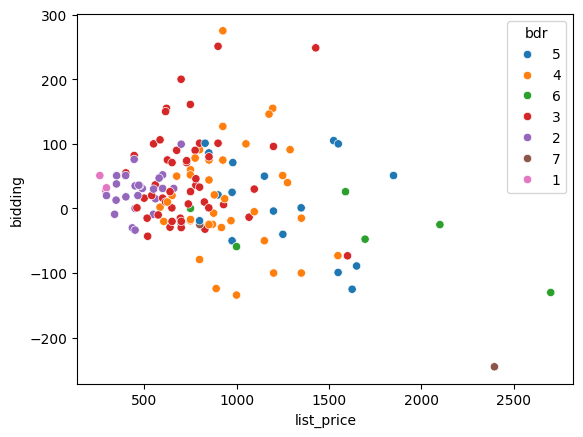

In [22]:
sns.scatterplot( x=df['list_price']/1000, y=df['bidding']/1000, hue = df['bdr'])

In [23]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  # To visualize

model = LinearRegression()

In [24]:
md = model.fit(df_cleaned[['list_price']], df_cleaned['bidding'])

In [25]:
r2_score = model.score(df_cleaned[['list_price']], df_cleaned['bidding'])

In [26]:
r2_score

0.07549425863089121

In [27]:
Y_pred = model.predict(df_cleaned[['list_price']])

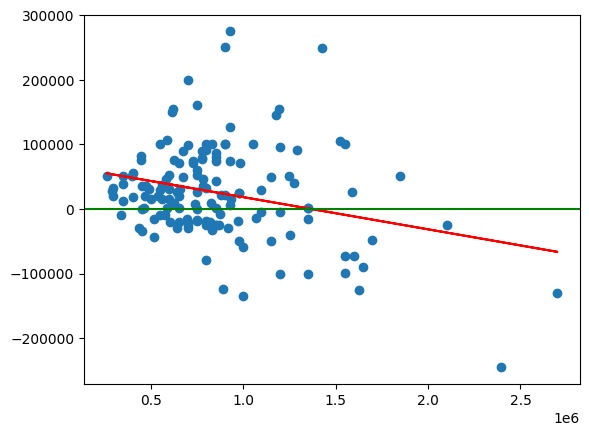

In [28]:
plt.scatter(df_cleaned[['list_price']], df_cleaned['bidding'])
plt.plot(df_cleaned[['list_price']], Y_pred, color='red')
plt.axhline(y=0, color='green', linestyle='-')
plt.show()

So offering much over asking price is reasonable as soon as you're buying the house in price range below \$1,000,000-\$1,500,000. More over, it's 

In [29]:
X = df_cleaned[['list_price']]
Y_pred = model.predict(X)

In [30]:
df_cleaned['pred'] = Y_pred

In [31]:
df_cleaned['pred_perc'] = df_cleaned['pred']/df_cleaned['list_price']

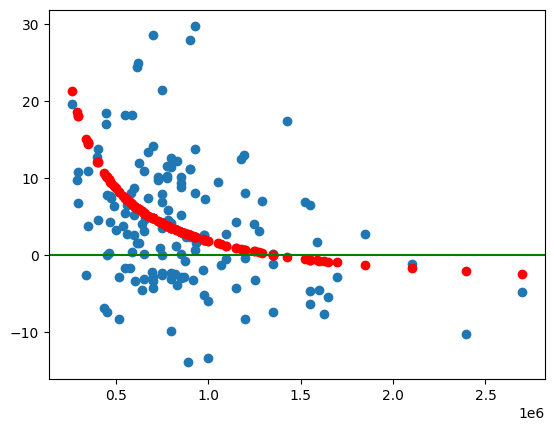

In [32]:
plt.scatter(df_cleaned[['list_price']], df_cleaned['bidding']/df_cleaned['list_price']*100)
plt.scatter(df_cleaned[['list_price']], df_cleaned['pred_perc'] *100, color='red')
plt.axhline(y=0, color='green', linestyle='-')
plt.show()

Wonderful observation! As soon as the listing price is much lower than 1000k, the sold price is up to 20% higher, than listing price. At the same time there's no need to give an offer much over asking price for the houses listed over 1000k. And you could ask a discount for the houses over 1500k. So the bidding wars are intensive on the lower end of houses in a good area. 